# Pomme de terre Disease Classification

### Importer les bibliotheques

In [3]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from sklearn import svm
import numpy as np

### Fixer les constantes

In [4]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=20

### Importer données dans un objet dataset tensorflow 

In [5]:
# créer un ensemble de données avec image_dataset_from_directory de TensorFlow et Keras
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [6]:
#dimension en nombre de batchs
len(dataset)

68

In [7]:
#afficher les classes
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Healthy', 'Potato___Late_blight']

In [8]:
#dimension du batch 1
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[2 2 2 0 0 0 0 0 2 2 2 2 0 2 0 2 2 2 0 2 0 2 0 0 2 0 0 1 2 2 0 0]


Chaque élément dans le jeu de données est un tuple. Le premier élément est un lot de 32 éléments d'images de taille 256*256 de 3 couches de couleurs RGB, et le deuxième élément est un lot de 32 éléments d'étiquettes de classe.

### Visualisez certaines des images de notre ensemble de données.

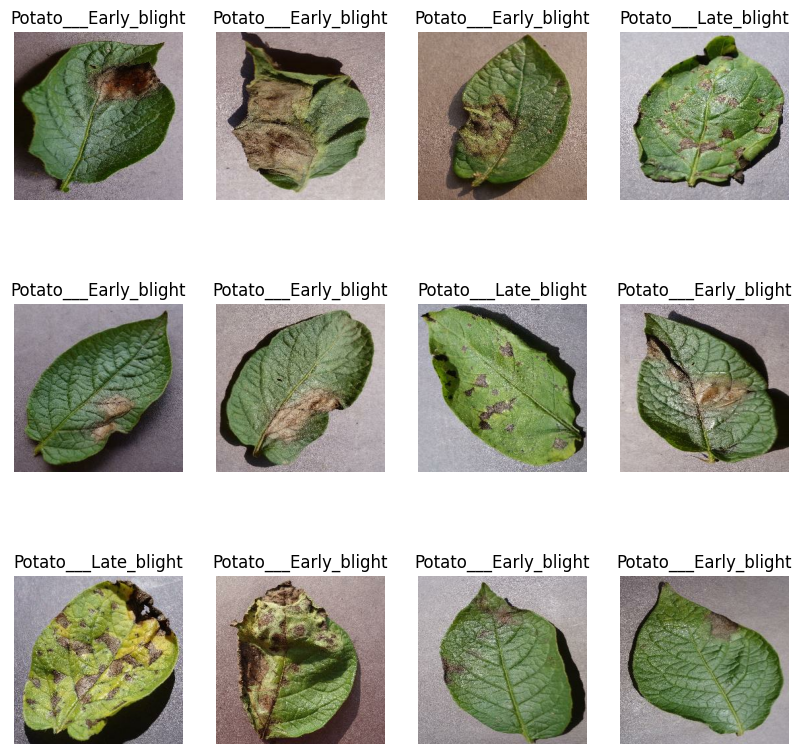

In [9]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

### Fonction pour diviser l'ensemble de données.

Le jeu de données devrait être subdivisé en trois sous-ensembles, à savoir :

- Entraînement : Jeu de données utilisé pendant l'entraînement.
- Validation : Jeu de données testé pendant l'entraînement.
- Test : Jeu de données testé après avoir entraîné un modèle.

Split manuel:

In [10]:
len(dataset)

68

In [11]:
# 80% de données pour l entrainement
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [12]:
train_ds = dataset.take(54)
len(train_ds)

54

In [13]:
# 20% pour le test et la validation
test_ds = dataset.skip(54)
len(test_ds)

14

In [14]:
# 10% pour la validation
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [15]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [16]:
test_ds = test_ds.skip(6)
len(test_ds)

8

Fonction pour slit du jeu de données:

In [17]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [18]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [19]:
len(train_ds) , len(val_ds), len(test_ds)

(54, 6, 8)

### Cache, Shuffle, et Prefetch jeux de données

In [20]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

 Ca permet d'optimiser les performances du chargement des données pendant l'entraînement en utilisant la mise en cache, le mélange aléatoire pour éviter tout biais d'ordre, et le prefetching pour anticiper le chargement des données suivantes. Cela peut contribuer à un processus d'entraînement plus efficace et accéléré.

### Redimensionnement et normalisation
Avant de fournir nos images au réseau, nous devrions les redimensionner à la taille souhaitée.
De plus, pour améliorer les performances du modèle, nous devrions normaliser la valeur des pixels de l'image (dans la plage de 0 à 1 en les divisant par 256).

In [21]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

### Data Augmentation


In [22]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
  ])

#### Appliquer Data Augmentation sur le Train Dataset

Deux opérations d'augmentation de données (retournement aléatoire et rotation aléatoire)

In [23]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [24]:
len(train_ds)

54

## Construire le modele

**SVM**

In [25]:
# Extraire les features et les labels pour les données d entrainement
train_features = []
train_labels = []

for images, labels in train_ds:
    # Applatir chaque image et ajouter aux train_features
    flattened_images = images.numpy().reshape(images.shape[0], -1)
    train_features.extend(flattened_images)
    
    # ajouter les labels au train_labels
    train_labels.extend(labels.numpy())

train_features = np.array(train_features)
train_labels = np.array(train_labels)

In [26]:
# Extraire les features et les labels pour les données de test
test_features = []
test_labels = []

for images, labels in test_ds:
    # Applatir chaque image et ajouter aux test_features
    flattened_images = images.numpy().reshape(images.shape[0], -1)
    test_features.extend(flattened_images)
    
    # ajouter les labels au test_labels
    test_labels.extend(labels.numpy())

test_features = np.array(test_features)
test_labels = np.array(test_labels)

In [27]:
# Modele SVM 
svm_classifier = svm.SVC()
svm_classifier.fit(train_features, train_labels)

SVC()

In [28]:
# Évaluer le SVM sur les données de test
accuracy = svm_classifier.score(test_features, test_labels)
print(f'Précision du SVM sur les données de test: {accuracy * 100:.2f}%')

Précision du SVM sur les données de test: 88.28%


### Architecture du modele CNN
Nous utilisons un réseau de neurones convolutif (CNN) couplé à une activation Softmax dans la couche de sortie.

In [32]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [33]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

### Compiler le Modele
Nous utilisons l'optimiseur "adam", la fonction de perte "SparseCategoricalCrossentropy" et la métrique "accuracy".

In [34]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [35]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=20,
)

Epoch 1/20


54/54 [==============================] - 69s 1s/step - loss: 0.9066 - accuracy: 0.4896 - val_loss: 0.8891 - val_accuracy: 0.4427
Epoch 2/20
54/54 [==============================] - 60s 1s/step - loss: 0.7197 - accuracy: 0.6175 - val_loss: 0.7496 - val_accuracy: 0.6302
Epoch 3/20
54/54 [==============================] - 55s 1s/step - loss: 0.5591 - accuracy: 0.7402 - val_loss: 0.4321 - val_accuracy: 0.8177
Epoch 4/20
54/54 [==============================] - 58s 1s/step - loss: 0.4267 - accuracy: 0.7975 - val_loss: 0.3570 - val_accuracy: 0.8542
Epoch 5/20
54/54 [==============================] - 56s 1s/step - loss: 0.3333 - accuracy: 0.8623 - val_loss: 0.4136 - val_accuracy: 0.8177
Epoch 6/20
54/54 [==============================] - 66s 1s/step - loss: 0.2297 - accuracy: 0.9115 - val_loss: 0.2772 - val_accuracy: 0.9010
Epoch 7/20
54/54 [==============================] - 59s 1s/step - loss: 0.2086 - accuracy: 0.9213 - val_loss: 0.2890 - val_accuracy: 0.9010
Epoch 8/20
54/54 [

**Nous obtenons une précision de 95.31 % pour notre ensemble de données de train.**

In [49]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 2s 231ms/step - loss: 0.0519 - accuracy: 0.9805


**Nous obtenons une précision de 88.67 % pour notre ensemble de données de test.**

### Tracer les courbes de précision (accuracy) et de perte (loss)

In [50]:
history
history.params

{'verbose': 1, 'epochs': 20, 'steps': 54}

In [52]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [53]:
type(history.history['loss'])

list

In [54]:
len(history.history['loss'])

20

In [55]:
history.history['loss'][:20] # lister les loss pour les 20 epochs

[0.9066252708435059,
 0.7197363376617432,
 0.5591382384300232,
 0.4267461597919464,
 0.33332306146621704,
 0.2297026813030243,
 0.20856638252735138,
 0.19657418131828308,
 0.1647273749113083,
 0.16152030229568481,
 0.14736208319664001,
 0.14380720257759094,
 0.1141166016459465,
 0.13829244673252106,
 0.0895480290055275,
 0.10185769945383072,
 0.11623553931713104,
 0.05738399550318718,
 0.09196315705776215,
 0.051358889788389206]

In [56]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

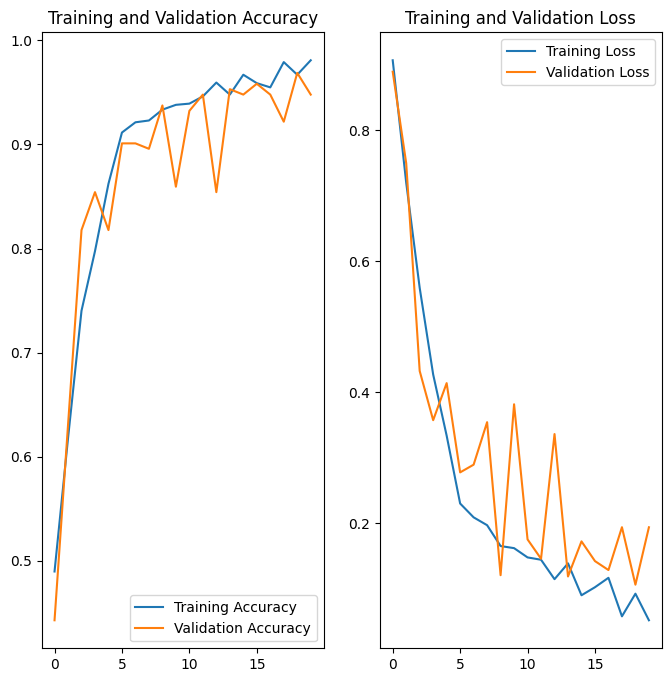

In [57]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Exécutez une prédiction sur une image d'échantillon

Premiere image à predire
label actuel: Potato___Early_blight
1/1 [==============================] - 0s 268ms/step
label predit: Potato___Early_blight


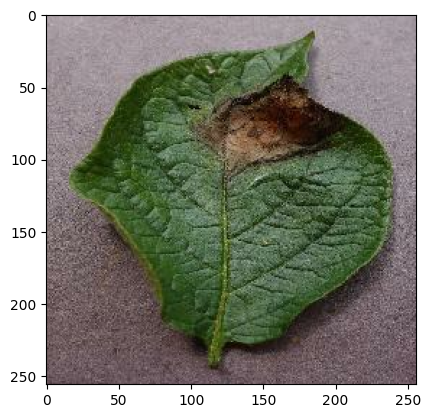

In [58]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("Premiere image à predire")
    plt.imshow(first_image)
    print("label actuel:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("label predit:",class_names[np.argmax(batch_prediction[0])])

### Ecrire une fonction pour l'inference

In [59]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

**Maintenant, effectuons une inférence sur quelques images d'échantillon**

1/1 [==============================] - 0s 44ms/step


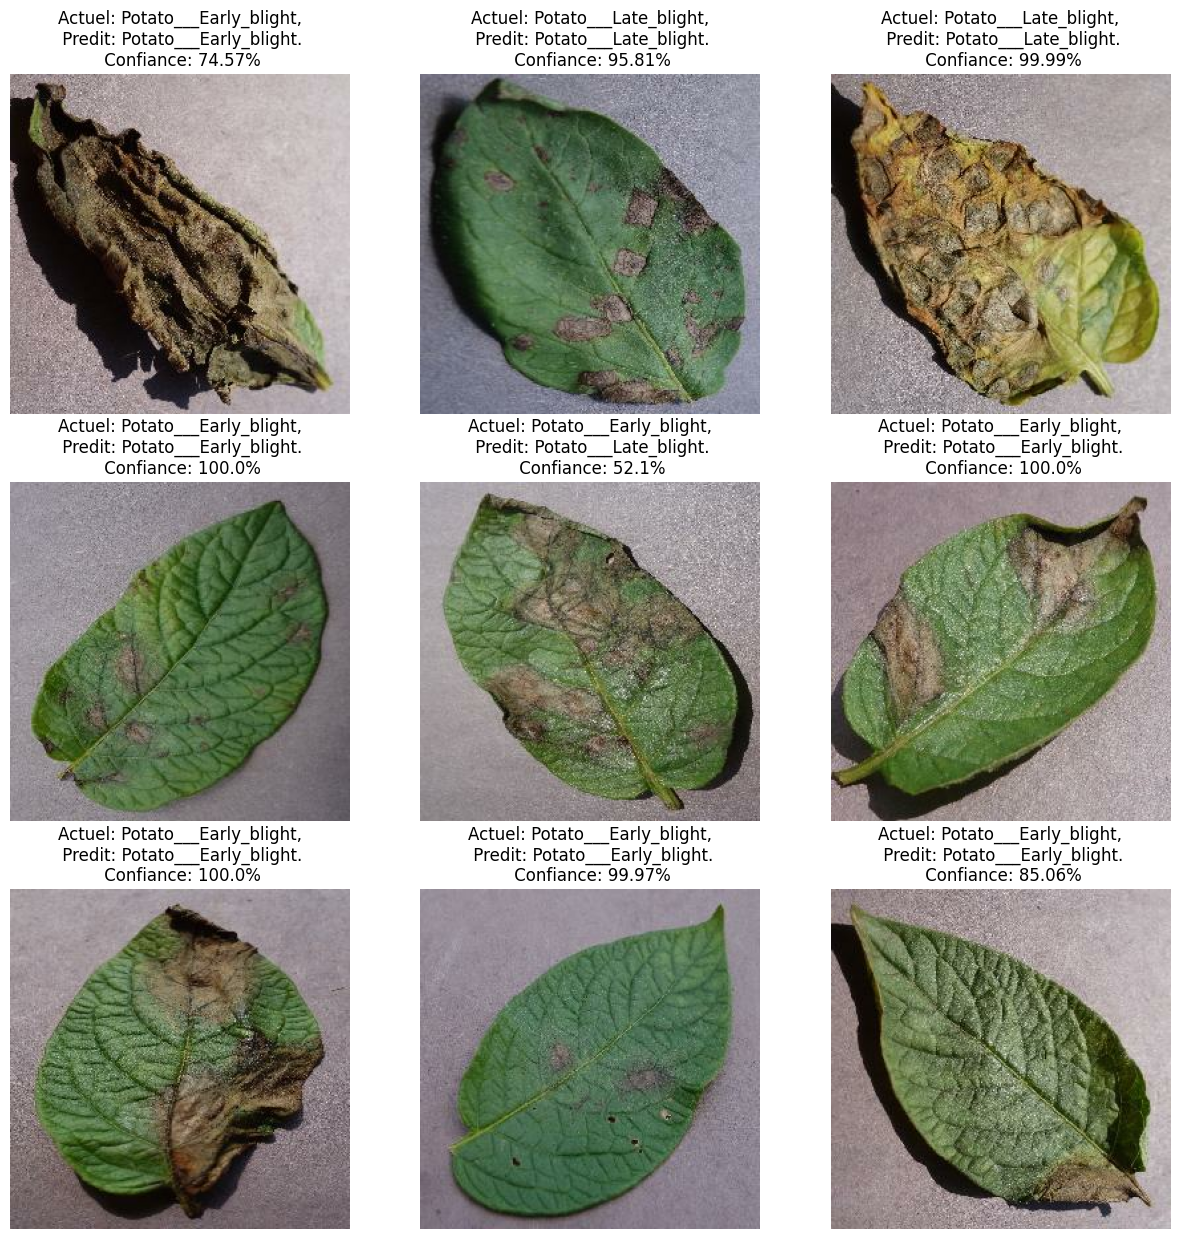

In [60]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actuel: {actual_class},\n Predit: {predicted_class}.\n Confiance: {confidence}%")
        
        plt.axis("off")

### Enregistrer le modele

Nous ajoutons le modèle à la liste des modèles en tant que nouvelle version.

In [48]:
model.save("../pomme de terre.h5")

d:\BADS\SEMESTRE 3\projet data science\Pomme de terre disease-classification_ webapp\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
